In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl
import math
import os
from numpy import diff

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import * 

os.environ["PATH"]='/home/ngrewal/flask/flask/bin:'+os.environ["PATH"]

### 5 cosmological parameters and 5 galaxy biases


(maybe try w dark energy equation of state)

In this notebook I will study a range of values for each variable by comparing the resulting simulated maps.

In [2]:
# standard parameter values
omega_b = 0.048
omega_m = 0.3
h = 0.7
n_s = 0.96
sigma_8 = 0.8
b1 = 1.42
b2 = 1.65
b3 = 1.60
b4 = 1.92
b5 = 2.00

cm = ["omega_b","omega_m","h","n_s","sigma_8","b1","b2","b3","b4","b5"]

smoothing = 20 # use 1/6 or 1/3 
nside = 256
N = 12*nside**2
map_len = 9         # sum of the number of lensing and clustering redshift bins

In [7]:
%%time 
# testing random seed code to make sure noise is identical in each simulation
# if A = B, then it worked

A = simulate_des_maps_bias(omega_b, omega_m, h, n_s, sigma_8, b1, b2, b3, b4, b5, smoothing, nside)
B = simulate_des_maps_bias(omega_b, omega_m, h, n_s, sigma_8, b1, b2, b3, b4, b5, smoothing, nside)

# compare all 9 maps in each simulation

for i in range(2): 
    if i == 0: # clustering maps
        for j in range(5):
            if (A[i][j]==B[i][j]).all() != True:
                print('The simulations are not identical')
    if i == 1: # lensing maps
        for j in range(4):
            if (A[i][j]==B[i][j]).all() != True:
                print('The simulations are not identical')


 ###################################################################
# - This is a config file for the program FLASK.                    #
# - Program parameters are identified by the colon that follows it  #
#   (so do not use it for anything else!).                          #
# - Parameters must be followed by their values which can be a      #
#   string or a sequence of up to 3 int, double or char variables.  #
#   Such sequences cannot mix different types.                      #
# - In case of a string with spaces, nothing can appear after it.   #
# - Another input type is the full line as a string.                #
# - Any other symbol or position of keywords and text are           #
#   completely arbitrary and chosen for aesthetic reasons.          #
#                                                                   #
# - All parameters used by the program should be listed here since  # 
#   there are no hard-wired default values.                         #
# - Addition/removal

In [3]:
# define range for each variable

# number of cosmological parameter values (length of range)
# higher value -> smaller dx
N_cm = 50

def find_range(x):
    y = .01*x
    return np.linspace(x-3*y,x+3*y,N_cm)

omega_b_range = find_range(omega_b)
omega_m_range = find_range(omega_m)
h_range = find_range(h)
n_s_range = find_range(n_s)
sigma_8_range = find_range(sigma_8)
b1_range = find_range(b1)
b2_range = find_range(b2)
b3_range = find_range(b3)
b4_range = find_range(b4)
b5_range = find_range(b5)

In [4]:
def make_maps(var,omega_b_a = np.full(N_cm,0.048),
                  omega_m_a = np.full(N_cm,0.3),
                  h_a       = np.full(N_cm,0.7),
                  n_s_a     = np.full(N_cm,0.96),
                  sigma_8_a = np.full(N_cm,0.8),
                  b1_a      = np.full(N_cm,1.42),
                  b2_a      = np.full(N_cm,1.65),
                  b3_a      = np.full(N_cm,1.60),
                  b4_a      = np.full(N_cm,1.92),
                  b5_a      = np.full(N_cm,2.00)):
    cmaps = np.zeros((N_cm,5,N)) # clustering maps
    lmaps = np.zeros((N_cm,4,N)) # lensing maps
    for i in range(N_cm):
        cmaps[i],lmaps[i] = simulate_des_maps_bias(omega_b = omega_b_a[i], 
                                                   omega_m = omega_m_a[i], 
                                                   h       = h_a[i], 
                                                   n_s     = n_s_a[i], 
                                                   sigma_8 = sigma_8_a[i], 
                                                   b1      = b1_a[i], 
                                                   b2      = b2_a[i], 
                                                   b3      = b3_a[i], 
                                                   b4      = b4_a[i], 
                                                   b5      = b5_a[i], 
                                                   smoothing=20, nside=256)
    path = os.path.join('Simulations')
    np.save(os.path.join(path, f'{var}_cmaps_{N_cm}'),cmaps)
    np.save(os.path.join(path, f'{var}_lmaps_{N_cm}'),lmaps)
    
    return cmaps,lmaps

### Simulate Maps

In [7]:
%%time 

' BUILD & SAVE MAPS '

#omega_b_cmaps,omega_b_lmaps = make_maps("omega_b",omega_b_a = omega_b_range)
omega_m_cmaps,omega_m_lmaps = make_maps("omega_m",omega_m_a = omega_m_range)

#h_cmaps,h_lmaps = make_maps("h",h_a = h_range)
#n_s_cmaps,n_s_lmaps = make_maps("n_s",n_s_a = n_s_range)
#sigma_8_cmaps,sigma_8_lmaps = make_maps("sigma_8",sigma_8_a = sigma_8_range)
#b1_cmaps,b1_lmaps = make_maps("b1",b1_a = b1_range)
#b2_cmaps,b2_lmaps = make_maps("b2",b2_a = b2_range)
#b3_cmaps,b3_lmaps = make_maps("b3",b3_a = b3_range)
#b4_cmaps,b4_lmaps = make_maps("b4",b4_a = b4_range)
#b5_cmaps,b5_lmaps = make_maps("b5",b5_a = b5_range)

CPU times: user 44min 2s, sys: 10.7 s, total: 44min 13s
Wall time: 22min 54s


In [35]:
'LOAD MAPS'

def load_maps(varname,N_cm=50):
    path = os.path.join('Simulations')
    cmaps = np.load(os.path.join(path, f'{varname}_cmaps_{N_cm}.npy'))
    lmaps = np.load(os.path.join(path, f'{varname}_lmaps_{N_cm}.npy'))
    return cmaps,lmaps
    

#omega_b_cmaps,omega_b_lmaps = load_maps("omega_b")
#omega_m_cmaps,omega_m_lmaps = load_maps("omega_m")
#h_cmaps,h_lmaps = load_maps("h")
#n_s_cmaps,n_s_lmaps = load_maps("n_s")
#sigma_8_cmaps,sigma_8_lmaps = load_maps("sigma_8")
#b1_cmaps,b1_lmaps = load_maps("b1")
#b2_cmaps,b2_lmaps = load_maps("b2")
#b3_cmaps,b3_lmaps = load_maps("b3")
#b4_cmaps,b4_lmaps = load_maps("b4")
#b5_cmaps,b5_lmaps = load_maps("b5")


---

### Calculating MFs

In [15]:
thr_ct = 10  
N = 12*nside**2

# find MFs of clustering and lensing maps for a range of cosmological parameter values
def find_mf(cmaps,lmaps):
    v = np.zeros((N_cm,map_len,thr_ct))
    v0 = np.zeros((N_cm,map_len,thr_ct))
    v1 = np.zeros((N_cm,map_len,thr_ct))
    v2 = np.zeros((N_cm,map_len,thr_ct))
    for i in range(N_cm):
        v[i],v0[i],v1[i],v2[i] = calc_mf_2maps(cmaps[i],lmaps[i],thr_ct,N)   
    return v,v0,v1,v2

omega_b_v,omega_b_v0,omega_b_v1,omega_b_v2 = find_mf(omega_b_cmaps,omega_b_lmaps)
#omega_m_v,omega_m_v0,omega_m_v1,omega_m_v2 = find_mf(omega_m_cmaps,omega_m_lmaps)
#h_v,h_v0,h_v1,h_v2 = find_mf(h_cmaps,h_lmaps)
#n_s_v,n_s_v0,n_s_v1,n_s_v2 = find_mf(n_s_cmaps,n_s_lmaps)
#sigma_8_v,sigma_8_v0,sigma_8_v1,sigma_8_v2 = find_mf(sigma_8_cmaps,sigma_8_lmaps)
#b1_v,b1_v0,b1_v1,b1_v2 = find_mf(b1_cmaps,b1_lmaps)
#b2_v,b2_v0,b2_v1,b2_v2 = find_mf(b2_cmaps,b2_lmaps)
#b3_v,b3_v0,b3_v1,b3_v2 = find_mf(b3_cmaps,b3_lmaps)
#b4_v,b4_v0,b4_v1,b4_v2 = find_mf(b4_cmaps,b4_lmaps)
#b5_v,b5_v0,b5_v1,b5_v2 = find_mf(b5_cmaps,b5_lmaps)

### Find gradients of MFs using 2 points

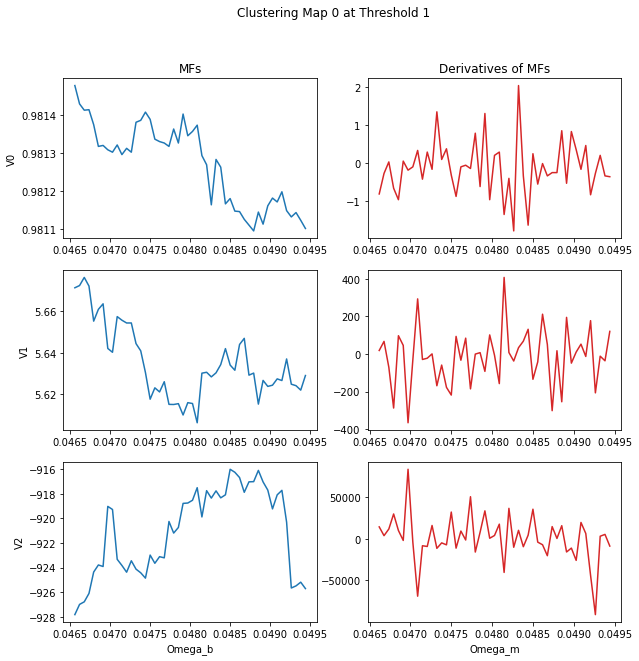

In [16]:
t_val = 1      # threshold value
map_num = 0      # map number (0-4 for clustering map, 5-8 for lensing)
map_array = ['Clustering','Clustering','Clustering','Clustering','Clustering','Lensing','Lensing','Lensing','Lensing']

# find slope in between omega_b values
d_v0 = diff(omega_b_v0[:,0,t_val])/diff(omega_b_range)
d_v1 = diff(omega_b_v1[:,0,t_val])/diff(omega_b_range)
d_v2 = diff(omega_b_v2[:,0,t_val])/diff(omega_b_range)

# plot MFs and derivatives
fig, ((ax1, ax2),(ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(10,10))
fig.suptitle(f'{map_array[map_num]} Map {map_num} at Threshold {t_val}')
ax1.plot(omega_b_range,omega_b_v0[:,map_num,t_val])
ax1.set_ylabel('V0')
ax1.set_title('MFs')
ax3.plot(omega_b_range,omega_b_v1[:,map_num,t_val])
ax3.set_ylabel('V1')
ax5.plot(omega_b_range,omega_b_v2[:,map_num,t_val])
ax5.set_xlabel('Omega_b')
ax5.set_ylabel('V2')
ax2.plot(omega_b_range[1:],d_v0, 'tab:red')
ax2.set_title('Derivatives of MFs')
ax4.plot(omega_b_range[1:],d_v1, 'tab:red')
ax6.plot(omega_b_range[1:],d_v2, 'tab:red')
ax6.set_xlabel('Omega_m');

#for ax in fig.get_axes():
#    ax.label_outer()

### Find Gradients of MFs using n points

In [17]:
# fit a line within a width (using a few points around) to find the gradient

def line_slope(b,range_cm,mf):
    '''
    Input: number of points used to build line (must be greater than 1)
    Output: array of slopes at each point
    '''
    slope = np.zeros(N_cm-1)  # slope between different cm values (minus one)
    a=0
    for i in range(N_cm-1):
        slope[i],c = np.polyfit(range_cm[a:b],mf[:,map_num,t_val][a:b],deg=1)
        a += 1
        b += 1
    return slope  

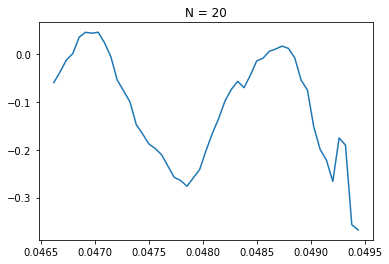

In [24]:
# use 20 for n
n = 20
plt.plot(omega_b_range[1:],line_slope(n,omega_b_range,omega_b_v0))
plt.title(f'N = {n}');

### Analysis of Range Size used to Build Line

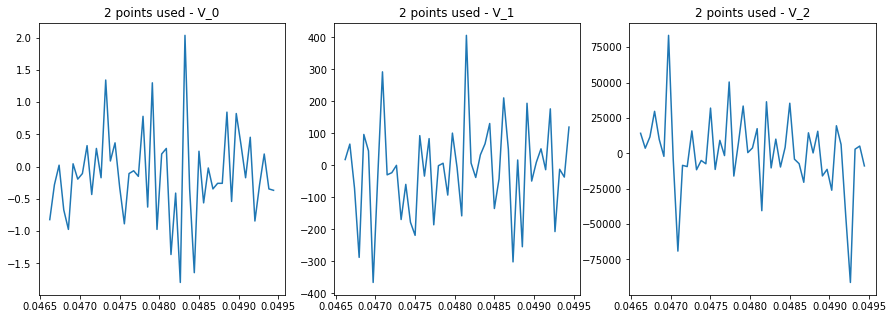

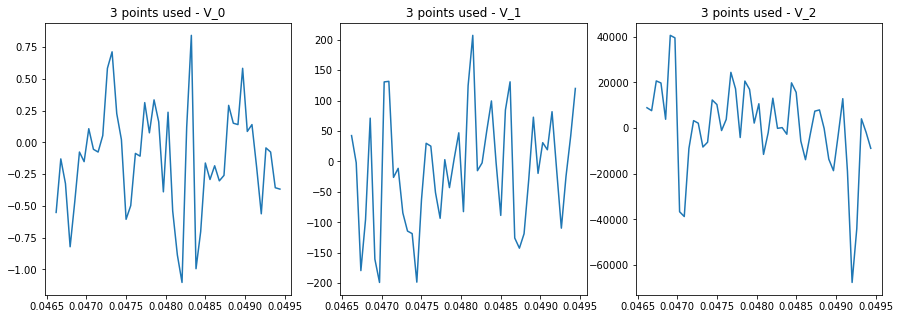

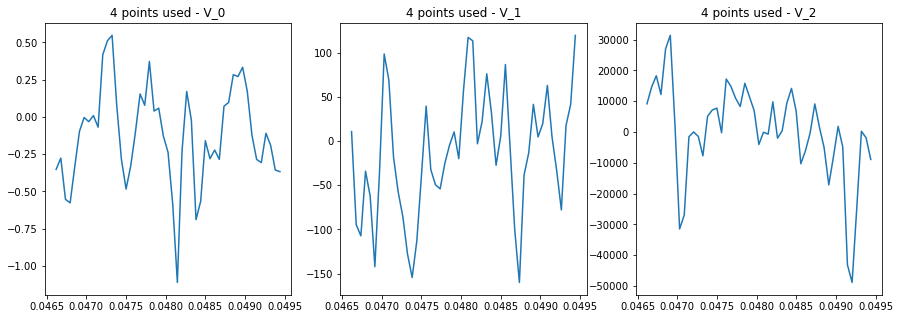

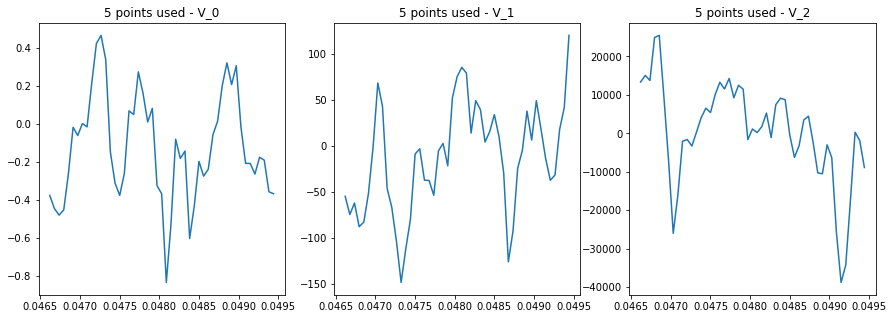

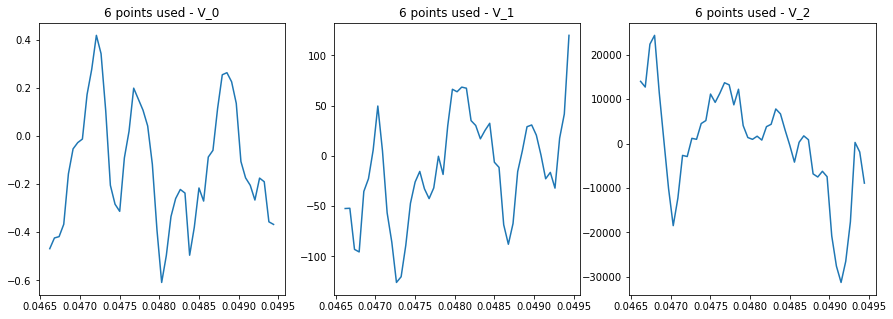

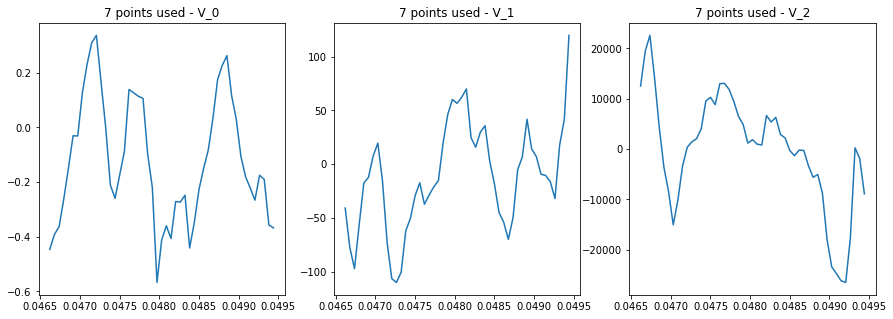

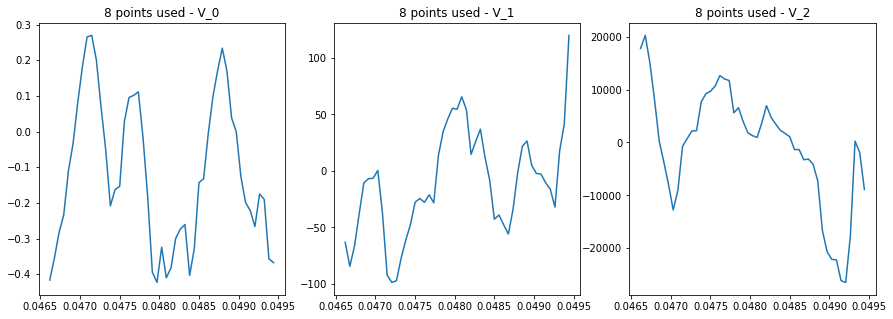

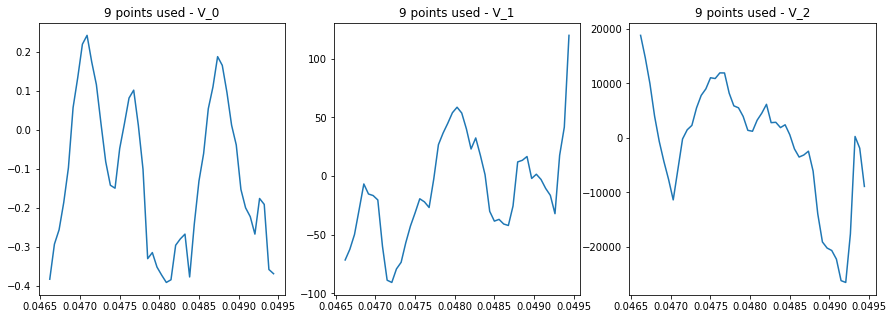

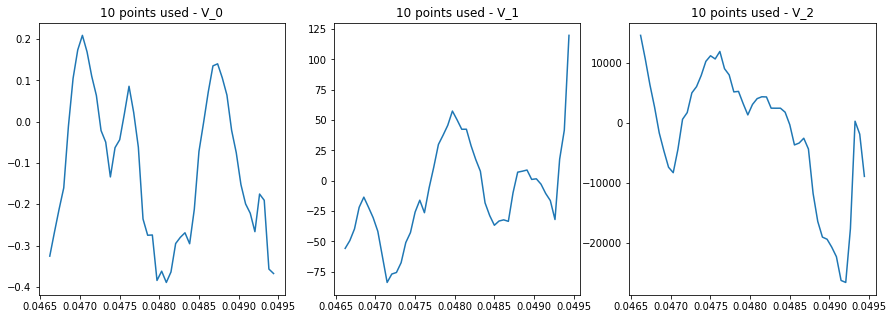

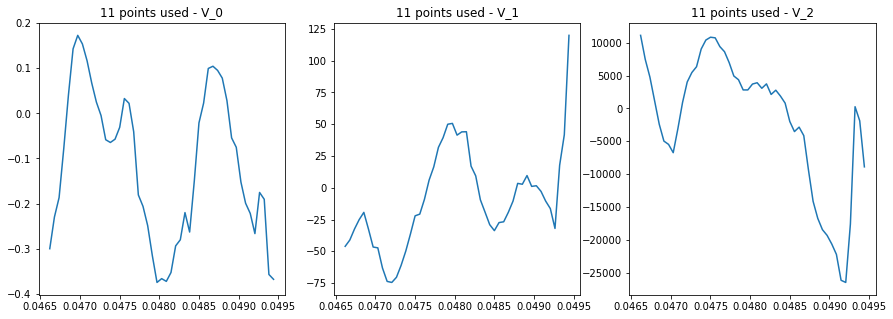

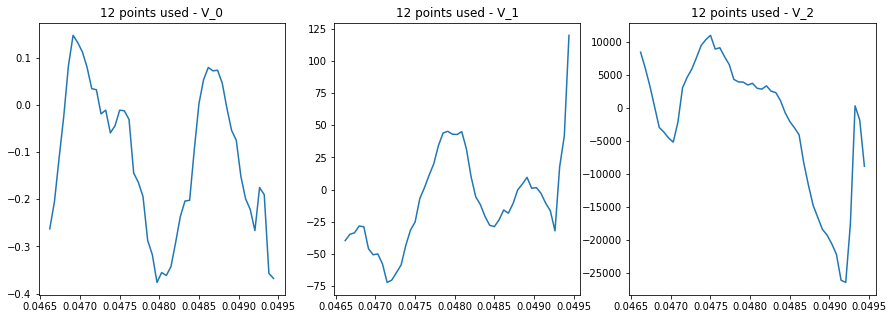

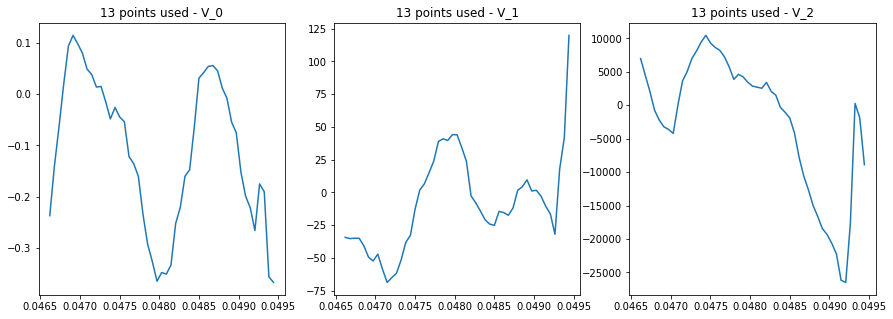

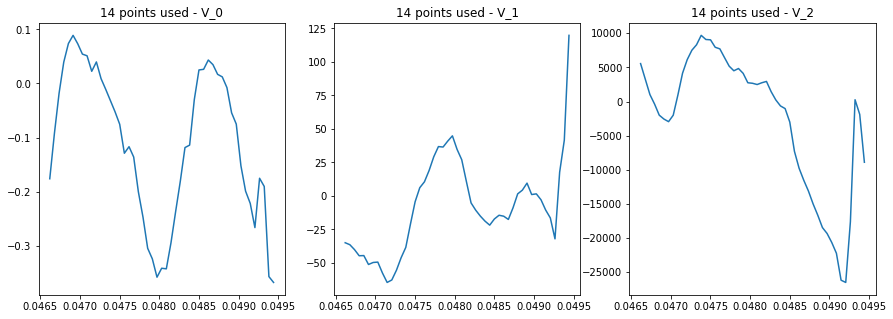

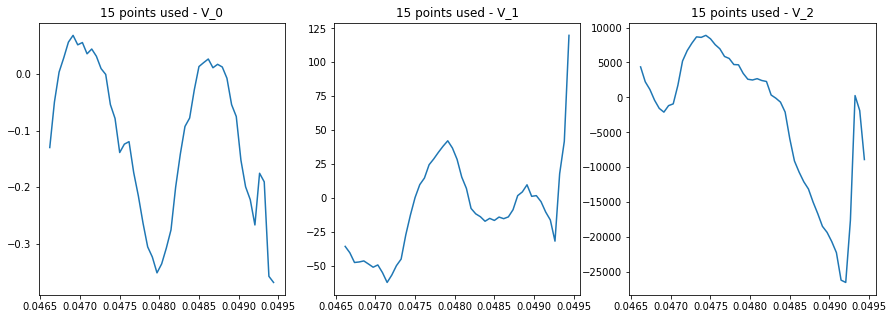

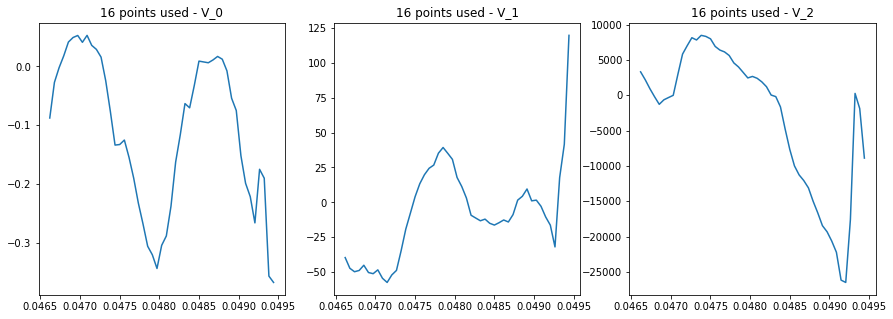

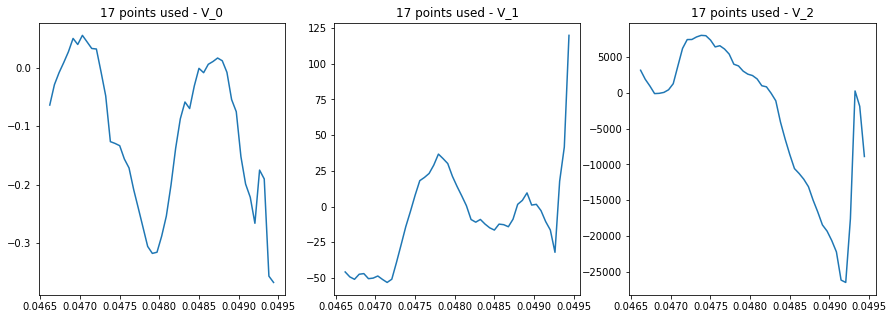

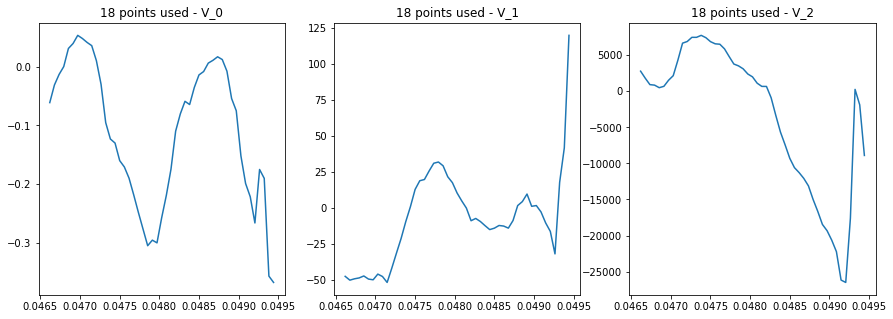

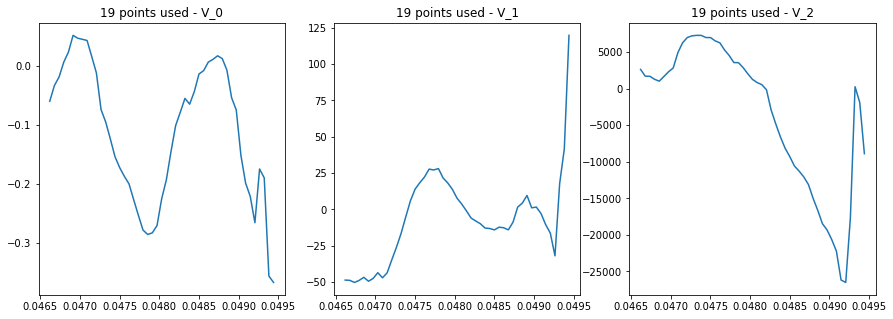

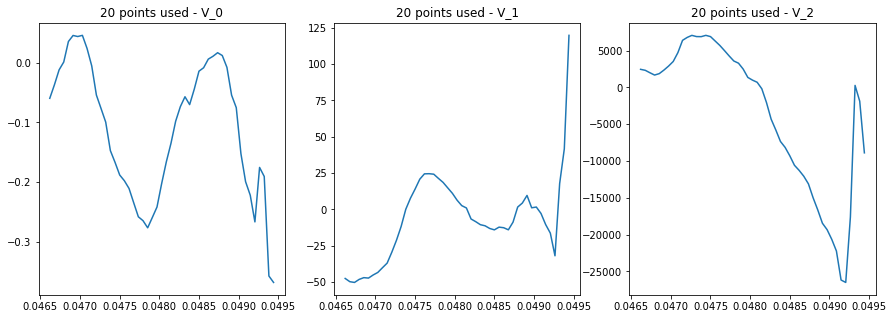

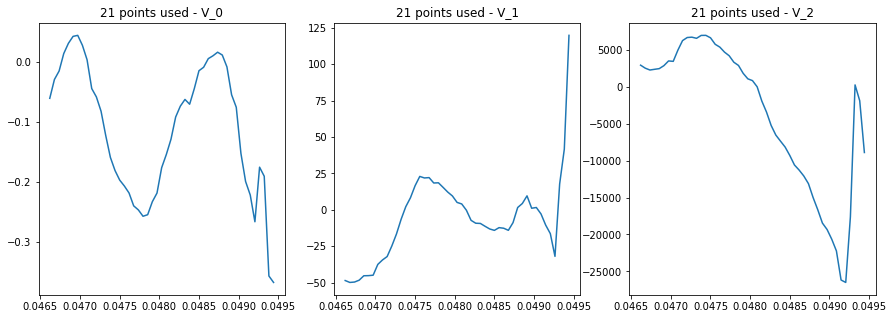

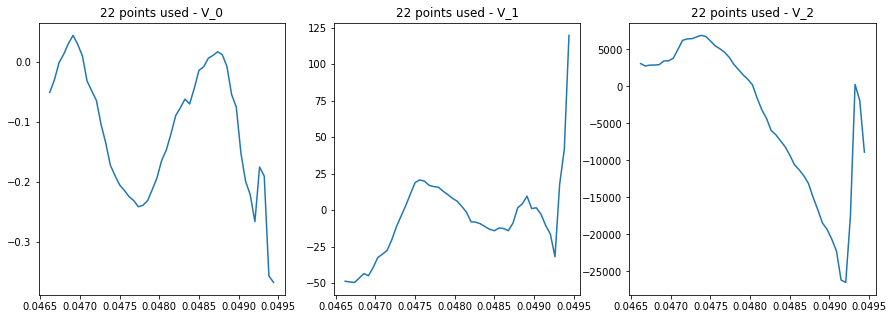

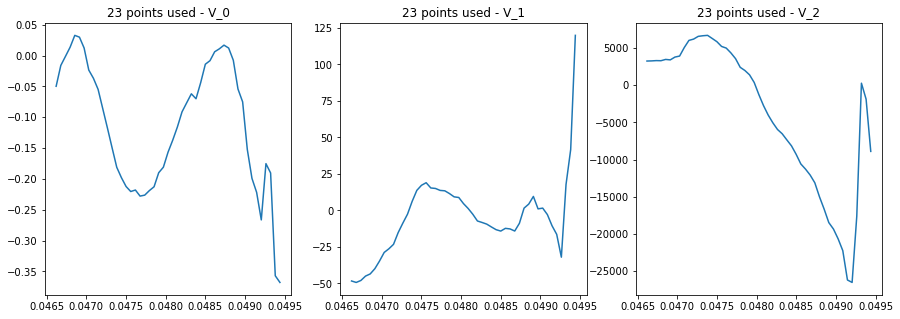

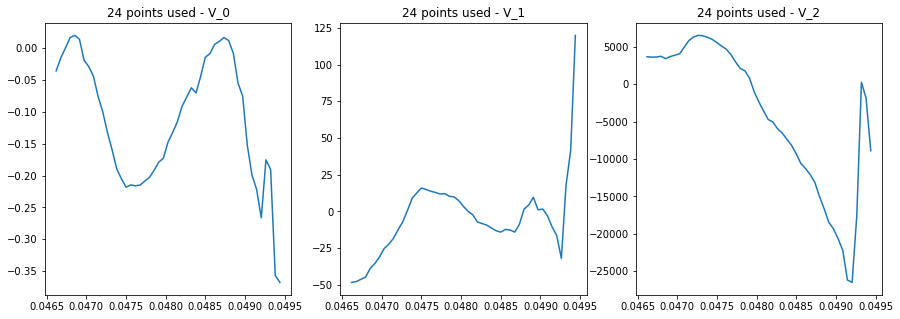

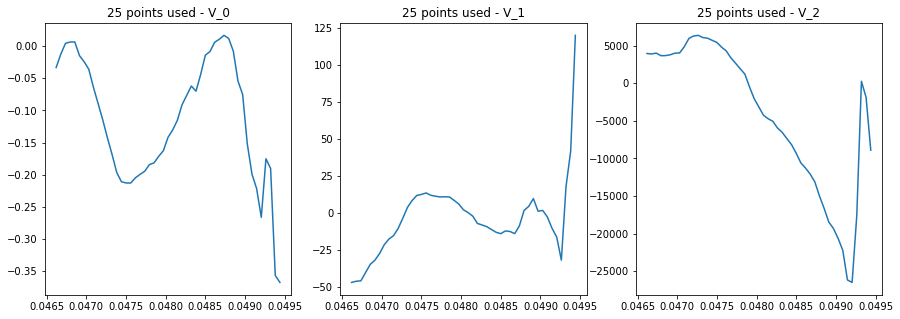

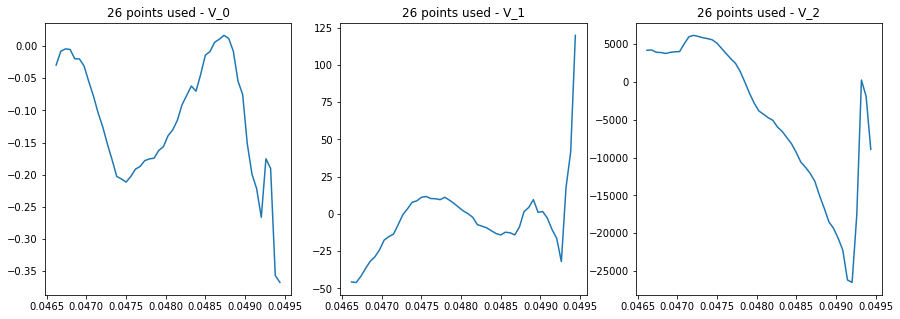

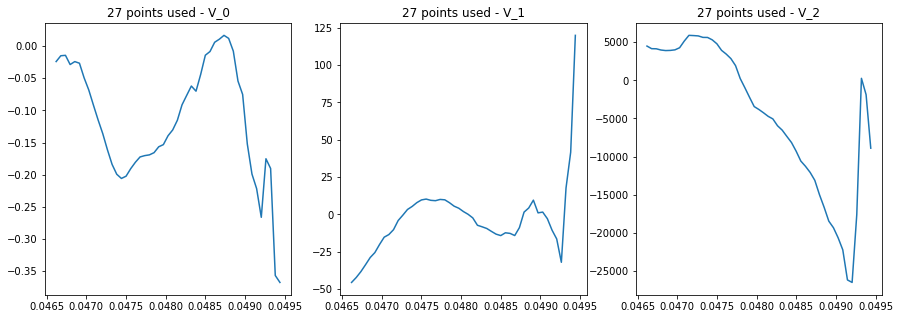

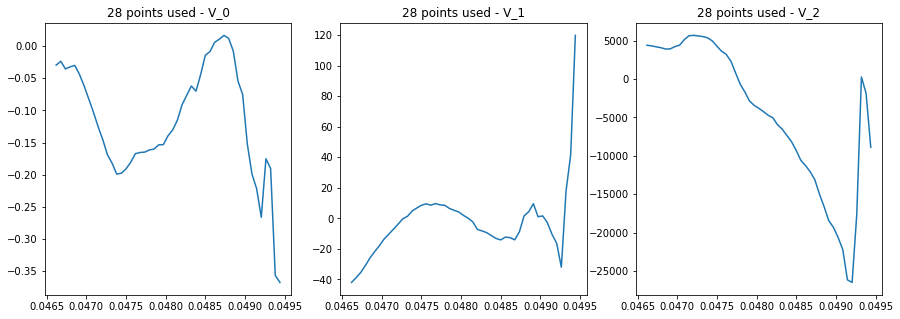

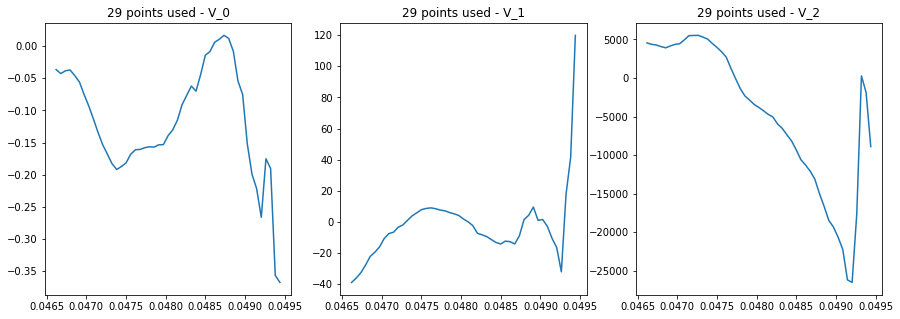

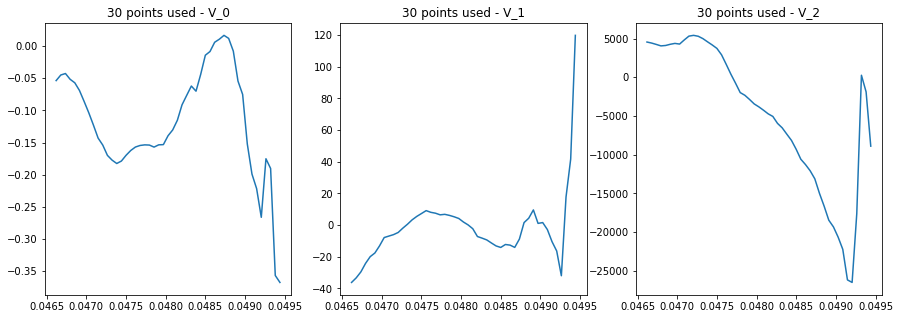

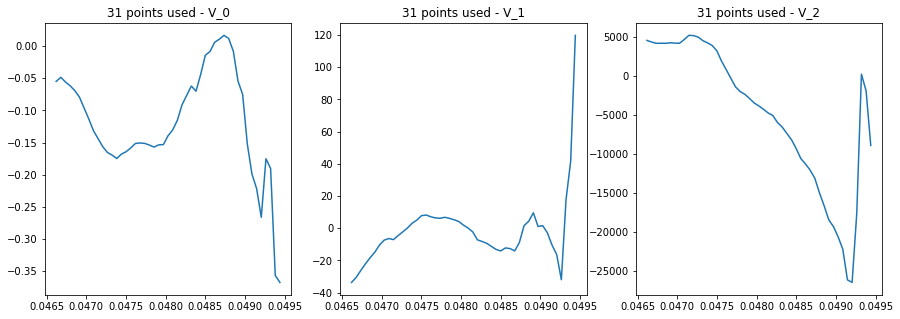

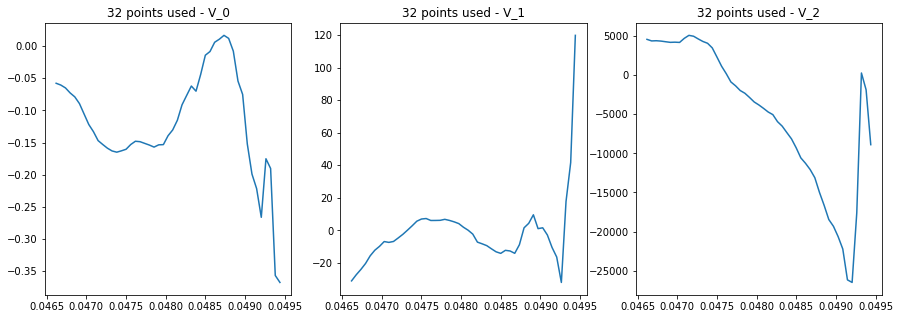

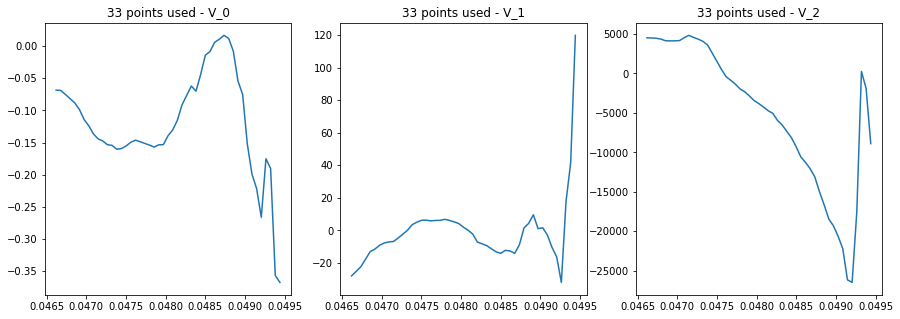

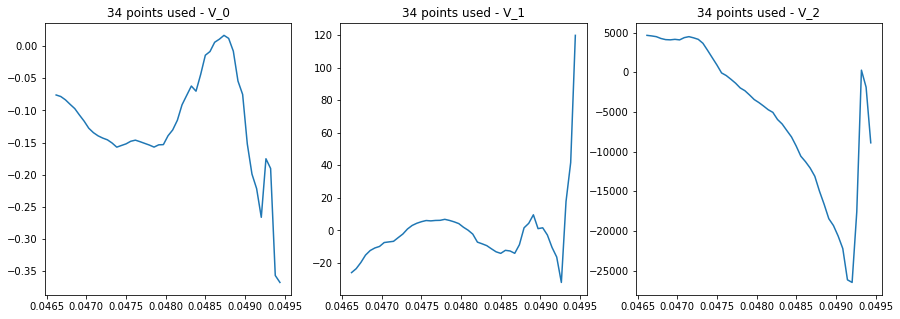

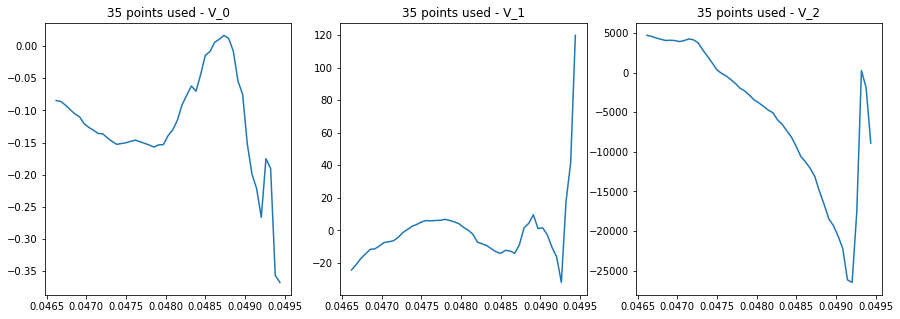

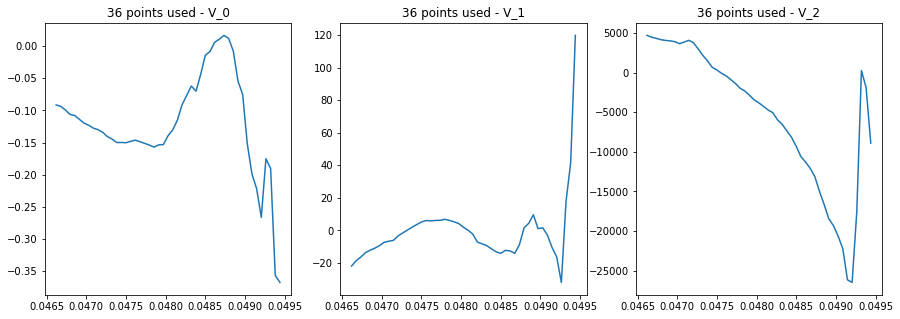

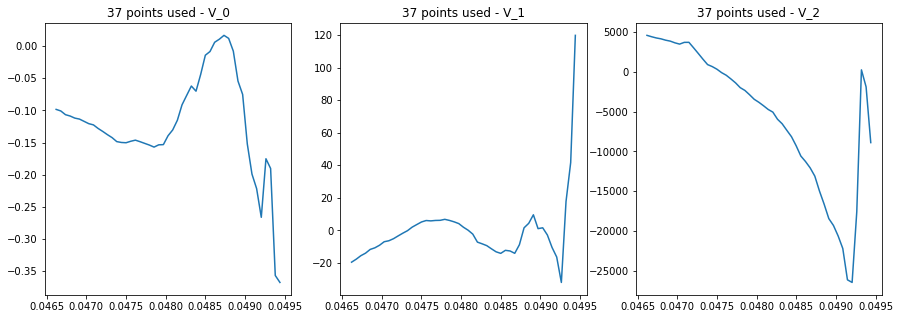

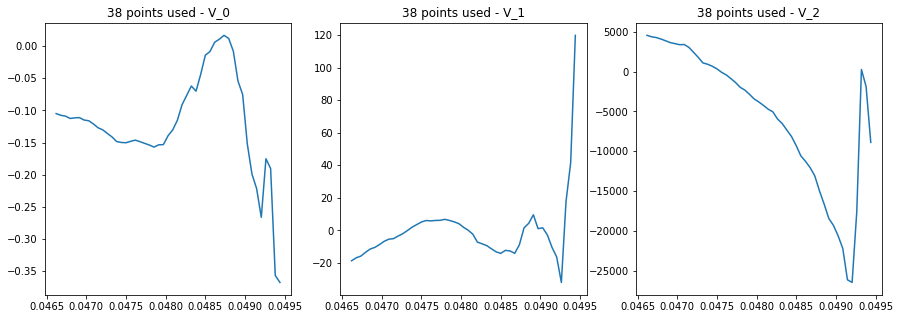

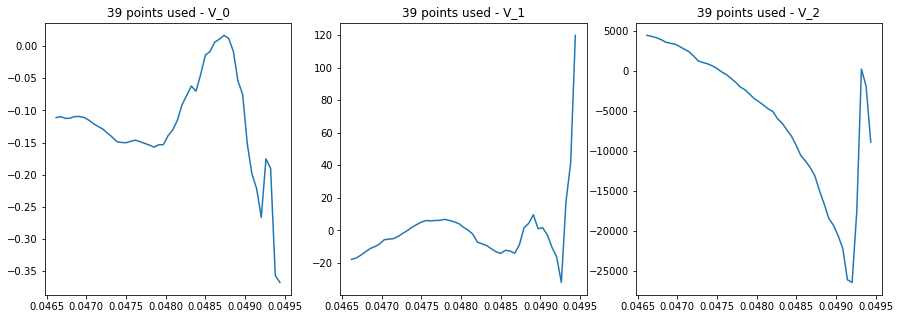

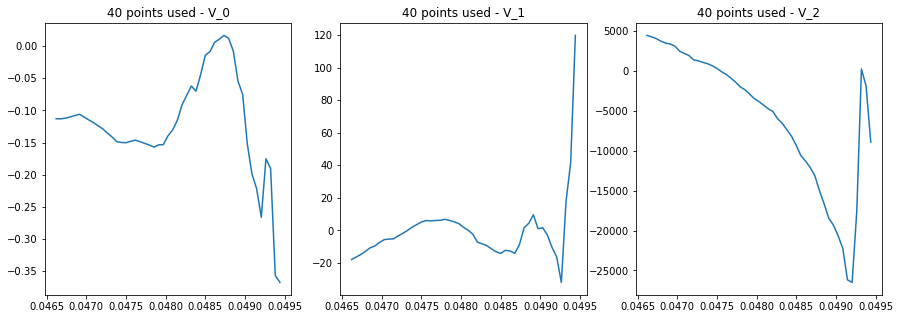

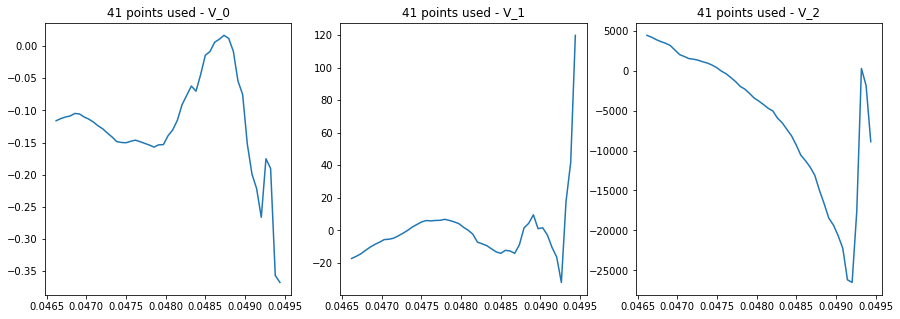

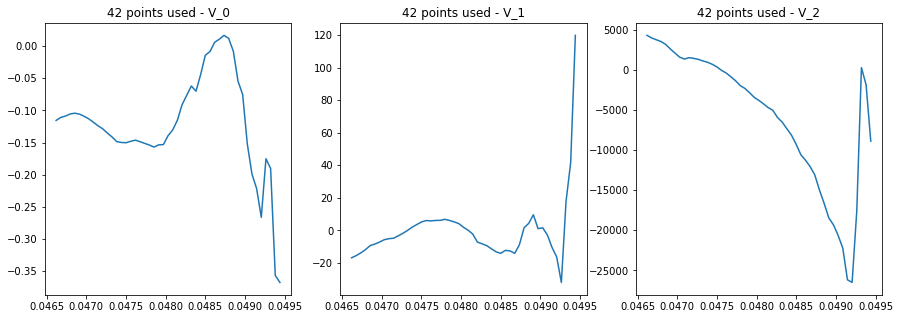

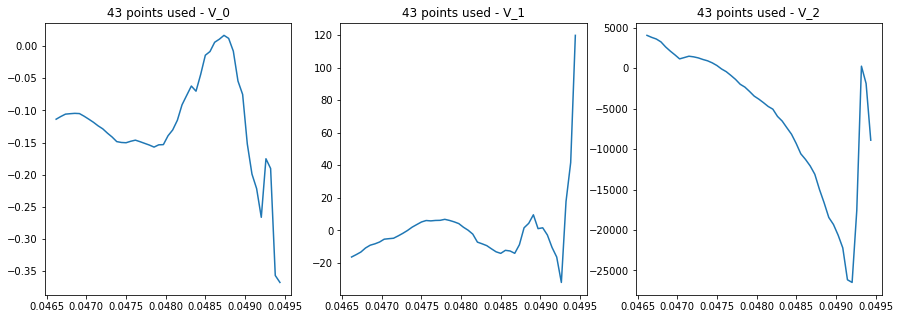

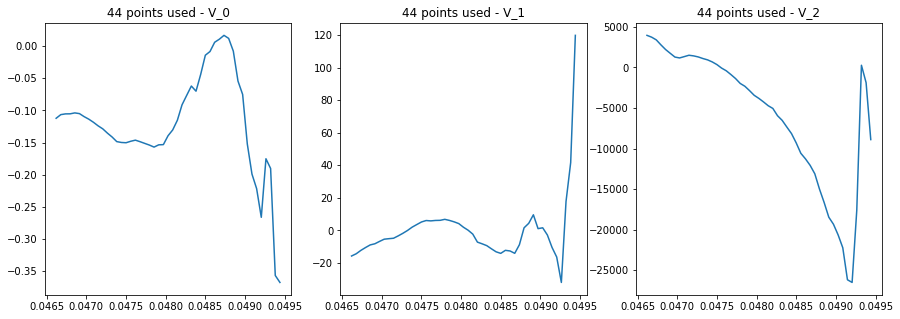

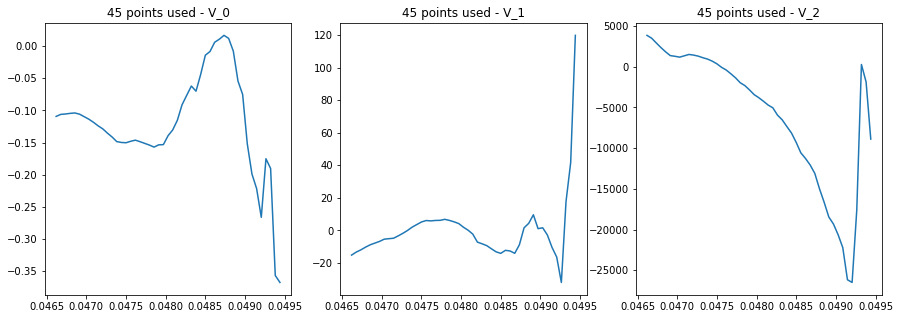

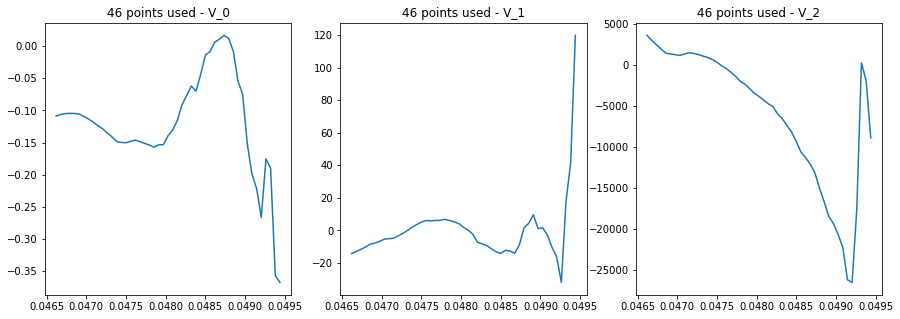

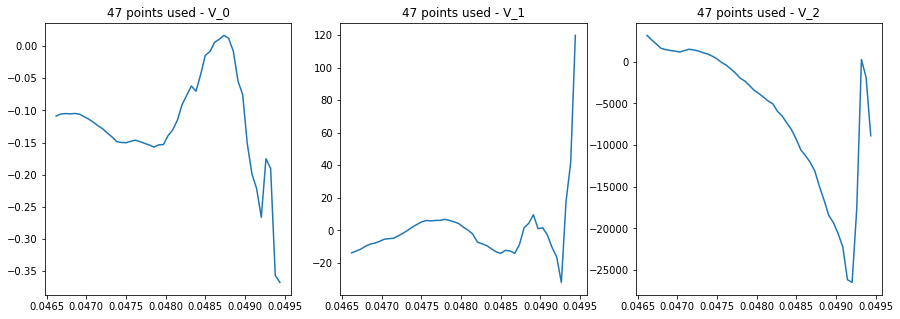

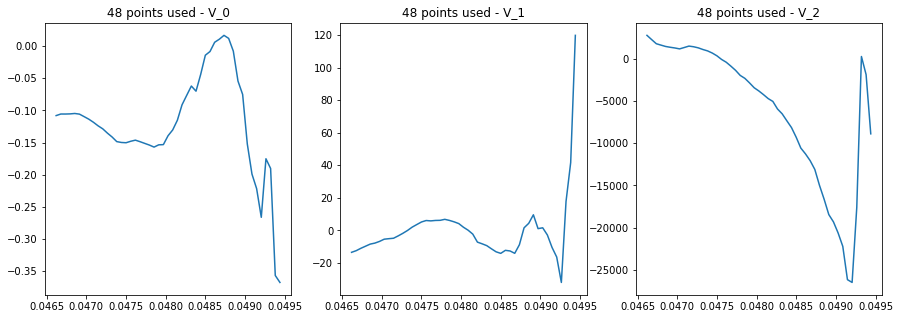

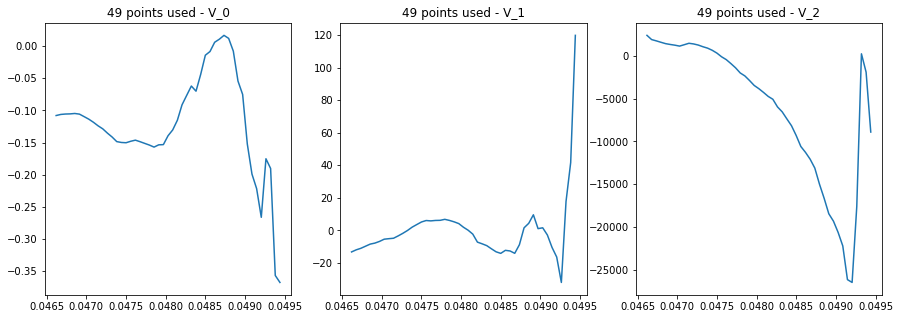

In [23]:
# plot gradients for different range sizes
for i in range(2,N_cm):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.plot(omega_b_range[1:],line_slope(i,omega_b_range,omega_b_v0))  # skip the first omega_m value
    ax1.set_title(f'{i} points used - V_0')
    ax2.plot(omega_b_range[1:],line_slope(i,omega_b_range,omega_b_v1))  # skip the first omega_m value
    ax2.set_title(f'{i} points used - V_1')
    ax3.plot(omega_b_range[1:],line_slope(i,omega_b_range,omega_b_v2))  # skip the first omega_m value
    ax3.set_title(f'{i} points used - V_2')
    plt.show();

In [ ]:
# manually find derivatives with respect omega_m
# only want gradient around fiducial value
# experiment with smaller range (more threshold counts)
# should be a straight line
# needs to work for all maps, thresholds
# optimise for each cosmological parameter



In [ ]:

    
    
diff(omega_m_range)/diff(omega_m_v0[:,0,t_val])
d_v1,c = diff(omega_m_range)/diff(omega_m_v1[:,0,t_val])
d_v2,c = diff(omega_m_range)/diff(omega_m_v2[:,0,t_val])

# plot MFs and derivatives
fig, ((ax1, ax2),(ax3,ax4), (ax5, ax6)) = plt.subplots(3,2,figsize=(10,10))
fig.suptitle(f'{map_array[map_num]} Map {map_num} at Threshold {t_val}')
ax1.plot(omega_m_range,omega_m_v0[:,map_num,t_val])
ax1.set_ylabel('V0')
ax1.set_title('MFs')
ax3.plot(omega_m_range,omega_m_v1[:,map_num,t_val])
ax3.set_ylabel('V1')
ax5.plot(omega_m_range,omega_m_v2[:,map_num,t_val])
ax5.set_xlabel('Omega_m')
ax5.set_ylabel('V2')
ax2.plot(omega_m_range[1:],d_v0, 'tab:red')
ax2.set_title('Derivatives of MFs')
ax4.plot(omega_m_range[1:],d_v1, 'tab:red')
ax6.plot(omega_m_range[1:],d_v2, 'tab:red')
ax6.set_xlabel('Omega_m');

#for ax in fig.get_axes():
#    ax.label_outer()

In [ ]:
omega_m_v,omega_m_v0,omega_m_v1,omega_m_v2 = find_mf(omega_m_cmaps,omega_m_lmaps)
plt.plot(omega_m_v[0][0],omega_m_v0[0][0]);
print('omega_m is:',min(omega_m_range),'and this is the first clustering map')